## GAN generator in action

In this notebook we are going to use a pre-trained GAN to generate new images. For that cause, only the generator network of the GAN is required (not the discriminator).

The generator model in the GAN architecture takes a point from the latent space as input and generates a new image. The latent space itself has no meaning. Through training, the generator learns to map points into the latent space with specific output images and this mapping will be different each time the model is trained.

Typically, new images are generated using random points in the latent space.

This notebook is meant to be visited after you run and understand notebook `01`.

##### Imports

Let's do some imports:

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from numpy.linalg import norm

##### Hyperparameters

In [48]:
img_size = 64 
img_channels = 3 

z_dim = 100 
feat_gen = 64 

# path to pre-trained model
load_path = 'models/model-0.pt'

# no need for gpu now, since no training will take place
device = 'cpu'

##### Generator architecture

In [49]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(z_dim, features_g * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv2 = nn.ConvTranspose2d( features_g * 8, features_g * 4, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d( features_g * 4, features_g * 2, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d( features_g * 2, features_g, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d( features_g, img_channels, 4, 2, 1, bias=False)

        self.bn1 = nn.BatchNorm2d(features_g * 8)
        self.bn2 = nn.BatchNorm2d(features_g * 4)
        self.bn3 = nn.BatchNorm2d(features_g * 2)
        self.bn4 = nn.BatchNorm2d(features_g)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.tanh(self.conv5(x))
        return x

##### Load the generator to our device and instantiate it with our saved weights

In [50]:
gen = Generator(z_dim, img_channels, feat_gen).to(device)

checkpoint = torch.load(load_path, map_location=torch.device(device))
gen.load_state_dict(checkpoint['generator'])

gen.eval()

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

##### Forward pass through our generator

Create a random latent vector and pass it through the generator to get an image.

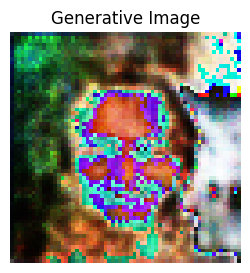

In [51]:
with torch.no_grad():
    random_latent_vector = torch.randn(1, z_dim, 1, 1).to(device)
    image_tensor = gen(random_latent_vector)
    image = transforms.functional.to_pil_image(image_tensor.squeeze(0))
    
    plt.figure(figsize=(3,3))
    plt.axis("off")
    plt.title("Generative Image")
    plt.imshow(image)

##### Performing vector arithmetic in latent space

In the following cell, we visualise two images generated from two random latent vectors. 

The points in the latent space can be kept and used in simple vector arithmetic to create new points in the latent space that, in turn, can be used to generate images. This allows for a targeted generation of images.

In the [2015 paper by A. Radford et al.](https://arxiv.org/pdf/1511.06434.pdf), the authors while exploring the latent space for GANs, they demonstrated the vector arithmetic with faces. For example, a face of a smiling woman minus the face of a neutral woman plus the face of a neutral man resulted in the face of a smiling man.

`smiling woman - neutral woman + neutral man = smiling man`

Starting from the two random vectors below, can you imagine how you could perform vector arithmetic with them, i.e. add them, substract them, multiply them, e.t.c.?

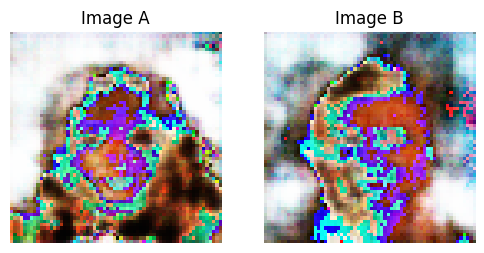

In [52]:
with torch.no_grad():
    l_a = torch.randn(1, z_dim, 1, 1).to(device)
    img_tensor_a = gen(l_a)
    img_a = transforms.functional.to_pil_image(img_tensor_a.squeeze(0))

    l_b = torch.randn(1, z_dim, 1, 1).to(device)
    img_tensor_b = gen(l_b)
    img_b = transforms.functional.to_pil_image(img_tensor_b.squeeze(0))

plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Image A")
plt.imshow(img_a)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Image B")
plt.imshow(img_b)

##### Interpolating between vectors in latent space

Similarly to performing arithmetic, the same paper demonstrated how you can interpolate between vectors in the latent space. The following few cells, provide possible ways of visualising this interpolation.

We can interpolate between one point in the latent space (the variable `a`) and another point (the variable `b`) to produce a smooth transition between images generated by the GAN along the latent space. 

It is recommended to use a geod "spherical linear interpolation", which effectively describes a ['geodesic'](https://en.wikipedia.org/wiki/Geodesic) ([mini-vid](https://www.youtube.com/watch?v=KsdIuVByfMc)).

See [this discussion](https://github.com/soumith/dcgan.torch/issues/14) and [this post](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/) for technical details and reference to the interpolation code.

In [53]:
# linear interpolation
def lerp(t, a, b):
    return a + t*(b - a)

# spherical linear interpolation
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/norm(low), high/norm(high)), -1.0, 1.0))
    so = np.sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high


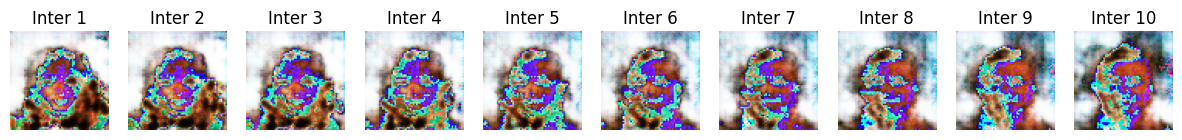

In [54]:
# create a static row of images 
num_steps = 10  # number of interpolation steps

# in order to interpolate between the latent vectors, we need to 
# convert them into numpy arrays and remove the empty dimensions: 
# from `(1,100,1,1)` to just `(100,)`
# `squeeze` and `unsqueeze` allow us to remove and add dimensions respectively
l_a_np = l_a.cpu().numpy().squeeze()
l_b_np = l_b.cpu().numpy().squeeze()

random_latent_vectors = []

for t in np.linspace(0, 1, num_steps):
    random_latent_vectors.append(slerp(t, l_a_np, l_b_np)) # test lerp or slerp

fig, axes = plt.subplots(1, num_steps, figsize=(15, 6))

for i, latent in enumerate(random_latent_vectors):
    # convert to torch tensor
    latent = torch.tensor(latent)
    # reshape tensor to (1,100,1,1)
    latent = latent.unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
    # generate image from latent vector
    img_tensor = gen(latent)
    # convert to PIL Image
    img = transforms.functional.to_pil_image(img_tensor.cpu().squeeze(0))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Inter {i+1}')

plt.show()

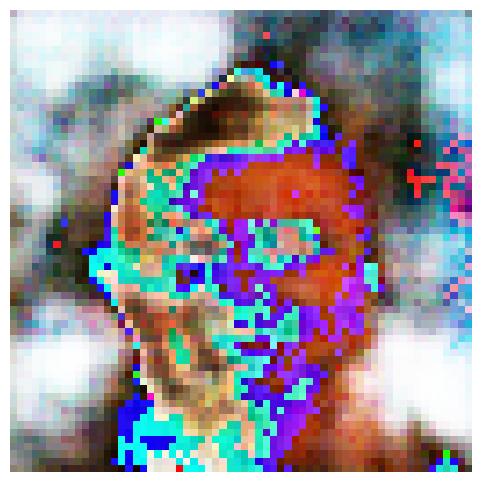

In [55]:
# create an interactive animation

num_steps = 100  # number of interpolation steps

latent_a_np = l_a.cpu().numpy().squeeze()
latent_b_np = l_b.cpu().numpy().squeeze()

random_latent_vectors = []

for t in np.linspace(0, 1, num_steps):
    random_latent_vectors.append(slerp(t, l_a_np, l_b_np)) # test lerp or slerp

img_list = []

for latent in random_latent_vectors:
    # convert to torch tensor
    latent = torch.tensor(latent)
    # reshape tensor to (1,100,1,1)
    latent = latent.unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
    # generate image from latent vector
    img_tensor = gen(latent)
    # convert to PIL Image
    img = transforms.functional.to_pil_image(img_tensor.cpu().squeeze(0))
    # add to image array
    img_list.append(img)
    
fig = plt.figure(figsize=(6,6))
plt.axis("off")
imgs = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())